# Siamese network

This notebook explains a possible improvement for the provious model, a resnet50 with dropout. Now we will use a siamese network but initialized of course with the network pretrained in the previous notebook. First, we will construct a confusion matrix from which we will extract hard examples that our network struggles to classify. Second, we will construct the siamese network and train it. Moreover, quite a lot of tools (Datasets, Loss Functions) will need to be created from scratch.

In [1]:
import torch
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn as nn
import tensorboardX
import numpy as np
from sklearn.metrics import f1_score
import os
import copy
import fastai
import matplotlib.pyplot as plt
import pylab
import pickle
from PIL import Image
import torch.nn.functional as F

In [2]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print("Device: " + str(torch.cuda.get_device_name(0)))

cuda
Device: Tesla K80


## 1. Building a confusion matrix

The idea behind siamese networks is that we want to increase the F score by increasing the distance of the feature vectors of samples belonging to different classses and reducing the distance of the feature vectors belonging to the same class. 
In order to have these pairs, we must save a confusion matrix with the names of the samples and where they were classified. To do this we create a new ImageFolderId dataset.

In [3]:
class ImageFolderId(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderId, self).__getitem__(index), self.imgs[index] #return image path

In [4]:
train_dir = '/home/user/snakes/train/'
validation_dir = '/home/user/snakes/validation/'

# Define training parameters 
size_batch = 4

# Like Albert Pumarola said in class, normalize data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# Define datasets
# Now the definition of the dataset for the trianing samples is a little bit different than before, we need to know
# the class path to build a confusion matrix
training_set = ImageFolderId(train_dir, transforms.Compose([transforms.RandomSizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),normalize]))
validation_set = torchvision.datasets.ImageFolder(validation_dir, transforms.Compose([transforms.RandomSizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),normalize]))
                                    
# Define dataloaders                               
train_loader = torch.utils.data.DataLoader(training_set, batch_size=size_batch, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=size_batch, shuffle=True, num_workers=2, pin_memory=True)

C = len(training_set.classes)
number_of_training_samples = len(training_set)
print("Number of classes C = " + str(C))
class_balance = torch.empty(C)
i=0
for cl in training_set.classes:
    # We want to penalize more the classes that are less frequent
    class_balance[i] = 1/len(os.listdir(os.path.join(train_dir, cl)))/number_of_training_samples
    i += 1

normalization_factor = class_balance.sum()
class_balance /= normalization_factor
class_balance = class_balance.to(device)

print("Weights provided to the loss:")
print(class_balance)

criterion = nn.CrossEntropyLoss(weight=class_balance)


/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:691: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


Number of classes C = 45
Weights provided to the loss:
tensor([0.0280, 0.0333, 0.0167, 0.0148, 0.0022, 0.0369, 0.0429, 0.0391, 0.0072,
        0.0116, 0.0108, 0.0202, 0.0166, 0.0097, 0.0249, 0.0179, 0.0121, 0.0397,
        0.0182, 0.0236, 0.0181, 0.0470, 0.0130, 0.0248, 0.0473, 0.0210, 0.0114,
        0.0349, 0.0233, 0.0261, 0.0078, 0.0054, 0.0217, 0.0293, 0.0420, 0.0045,
        0.0116, 0.0482, 0.0098, 0.0274, 0.0141, 0.0220, 0.0045, 0.0416, 0.0169],
       device='cuda:0')


We load the best model with dropout to construct the confusion matrix.

In [5]:
model = torchvision.models.resnet50(pretrained=True, progress=True)

num_ftrs = model.fc.in_features

# Add dropout layers
model.layer4[1].relu = nn.Sequential(
    nn.Dropout2d(0.15),
    nn.ReLU(inplace=True)
)
model.layer4[2].relu = nn.Sequential(
    nn.Dropout2d(0.15),
    nn.ReLU(inplace=True)
)
# Change the last layer to classify 45 classes instead of 1000 and add dropout
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, C)
)
# Now load the pretrained model with dropout
model_weights_path = '/home/user/finetuning/resnet50_snakes_drop_Ep_28_Acc_0.626_F_0.509.pth'
model_weights = torch.load(model_weights_path)
model.load_state_dict(model_weights)
# Now set the model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Basically we make a forward pass to all the samples in the training set and build the confusion matrix.

In [ ]:
# Now make a forward pass through all the training set and build a confusion matrix saving each sample-id
model = model.to(device)

# The confusion matrix will contain all ids that are missclassified
confusion_matrix = [[[] for col in range(45)] for row in range(45)]
for inputs, labels in train_loader:
    idxs = labels[0]
    labels = labels[1]
    inputs = inputs[0].to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu()
    indices = torch.eq(labels, preds).numpy()
    print("Labels:")
    print(labels)
    print(preds)
    wrong_classification = np.where(indices == 0)
    correct_classification = np.where(indices == 1)
    print(wrong_classification[0])
    for i in wrong_classification[0]:
        print("Sample number " + str(i)+ " has been missclassified")
        print("It was a sample of class: " + str(labels[i].item()))
        print("But it has been classified as: " + str(preds[i].item()))
        print("The name of the image is: " + str(idxs[i]))
        confusion_matrix[labels[i]][preds[i].item()].append(idxs[i])
    for i in correct_classification[0]:
        confusion_matrix[labels[i]][preds[i].item()].append(idxs[i])
    break
# RUN BELOW LINES TO SAVE THE CONFUSION MATRIX WITH IDs
# with open('/home/user/confusion_matrix', 'wb') as f:
#     pickle.dump(confusion_matrix, f)


## 2. Creating the Siamese

### 2.1 Dataset

Here is where things get more interesting. To train a siamese network, we need image pairs, so we need to create a PairsDataset class that picks pairs __taking into account the proportion of missclassified samples. Thanks to this, we choose image pairs that our network is likely to confuse__.

In [6]:
# Once the confusion matrix is created, a new dataset to sample pairs has to be created
class PairsDataset(torch.utils.data.Dataset):
    
    def __init__(self, confusion_mat_paths, confusion_mat_counter, transform):
        # List of lists (matrix like) containing the ids in the training set
        self.confusion_matrix_paths = confusion_mat_paths
        # Matrix (C x C) containing the number of classified samples: The rows are the actual class and the columns the 
        # predicted class. A typical confusion matrix.
        self.confusion_matrix_counter = confusion_mat_counter
        self.C = 45 # number of classes
        self.transform = transform
    
    # We override __getitem_method
    def __getitem__(self,index):
        # We'll sample by columns or rows randomly. 0: row, 1: col
        row_or_col = np.random.binomial(1,0.5)
        if(row_or_col == 0):
            # We sample along an entire row (Samples will be of same class) Y = 0
            
            # We take one class randomly to compare, this could be done with class proportion, but now let us leave it like this
            rnd_idx = int(np.random.randint(0, self.C, 1))
            # FIRST, take a correctly classified image
            correctly_classified_images = self.confusion_matrix_paths[rnd_idx][rnd_idx]
            img_0_idx = int(np.random.randint(0,len(correctly_classified_images),1))
            img_0_name = correctly_classified_images[img_0_idx]

            # SECOND, take a missclassified image
            non_null_indices = np.where(self.confusion_matrix_counter[rnd_idx, :] != 0)[0]
            row = self.confusion_matrix_counter[rnd_idx, non_null_indices]
            proportion_of_predictions = row/np.sum(row)
            
            choosen_class = rnd_idx
            # This while loop assures that a pair is composed of a correctly classified image and a missclassified image
            while(choosen_class == rnd_idx):
                # We sample taking into account the distribution of our missclassifications
                choosen_class = np.random.choice(non_null_indices, p=proportion_of_predictions)
            
            # Now pick an image from the confusion matrix with image names that we created before
            missclassified_images = self.confusion_matrix_paths[rnd_idx][choosen_class]    
            number_of_images = len(missclassified_images)
            img_1_idx = int(np.random.randint(0, number_of_images, 1))
            img_1_name = missclassified_images[img_1_idx]

            # Now we have the two images, let us transform them and build a tensor for each one
            img0 = Image.open(img_0_name)
            img1 = Image.open(img_1_name)
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            # We return both images and the label (0 because the images belong to the same class)
            return img0, img1, torch.from_numpy(np.array([int(0)], dtype=np.float32))


        else:
            
            # We sample along an entire column (Samples will be of different class) Y = 1
            # We take one class randomly to compare, this could be done with class proportion, but now let us leave it like this
            rnd_idx = int(np.random.randint(0, self.C, 1))
            
            # FIRST, take a correctly classified image
            correctly_classified_images = self.confusion_matrix_paths[rnd_idx][rnd_idx]
            img_0_idx = int(np.random.randint(0,len(correctly_classified_images),1))
            img_0_name = correctly_classified_images[img_0_idx]

            # SECOND, take a missclassified image
            non_null_indices = np.where(self.confusion_matrix_counter[:, rnd_idx] != 0)[0]
            
            col = self.confusion_matrix_counter[non_null_indices, rnd_idx]
            proportion_of_predictions = col/np.sum(col)
            
            choosen_class = rnd_idx
            # This while loop assures that a pair is composed of a correctly classified image and a missclassified image
            while(choosen_class == rnd_idx):
                # We sample taking into account the distribution of our missclassifications
                choosen_class = np.random.choice(non_null_indices, p=proportion_of_predictions)
                
            # Now pick an image from the confusion matrix with image names that we created before
            missclassified_images = self.confusion_matrix_paths[choosen_class][rnd_idx]    
            number_of_images = len(missclassified_images)
            img_1_idx = int(np.random.randint(0, number_of_images, 1))
            img_1_name = missclassified_images[img_1_idx]
            
            # Now we have the two images, let us transform them and build a tensor for each one
            img0 = Image.open(img_0_name)
            img1 = Image.open(img_1_name)
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            # We return the images and a 1 as a label because images belong to different classes
            return img0, img1, torch.from_numpy(np.array([int(1)], dtype=np.float32))
    
    def __len__(self):
        number_of_pairs = 0
        for i in range(0, np.shape(self.confusion_matrix_counter)[0]):
            number_of_pairs_in_row = self.confusion_matrix_counter[i,i] * (np.sum(self.confusion_matrix_counter[i, :]) - self.confusion_matrix_counter[i,i])
            number_of_pairs_in_col = self.confusion_matrix_counter[i,i] * (np.sum(self.confusion_matrix_counter[:, i]) - self.confusion_matrix_counter[i,i])
            number_of_pairs += 0.5 * number_of_pairs_in_col + 0.5 * number_of_pairs_in_row
        return int(number_of_pairs)

In [17]:
# Now load the confusion matrix
with open('/home/user/confusion_matrix','rb') as f:
    confusion_matrix = pickle.load(f)
cm = np.zeros((45,45))
for i in range(45):
        for j in range(45):
                cm[i,j] = len(confusion_matrix[i][j])
# Dataset and dataloader
training_set_pairs = PairsDataset(confusion_matrix, cm,transforms.Compose([transforms.RandomSizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),normalize]))
dataloader_pairs = torch.utils.data.DataLoader(training_set_pairs, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

### 2.2 Network

The important thing to notice is that we are passing as argument a pretrained model.

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self, pretrained_model):
        super(SiameseNetwork, self).__init__()
        # remove the last layer of resnet (We want only the Feature vector)
        self.cnn_no_fc = torch.nn.Sequential(*(list(pretrained_model.children())[:-1]))
        print(self.cnn_no_fc)
    def forward_once(self, x):
        output = self.cnn_no_fc(x)
        return output
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    def save_model_weights(self, i):
        torch.save(self.cnn_no_fc.state_dict(), '/home/user/siamese/resnet50_snakes_siamese_{}.pth'.format(i))

In [9]:
siamese_net = SiameseNetwork(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

### 2.3 Loss Function

I used the contrastive loss function proposed by Hadsell, Chopra and LeCun in http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [11]:
criterion_siamese = ContrastiveLoss()
optimizer = torch.optim.Adam(siamese_net.parameters(),lr = 0.0005 )

### 2.4 Training

In [ ]:
num_epochs = 10
for epoch in range(0,num_epochs):
    for i, data in enumerate(dataloader_pairs,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        print(img0.size())
        print(label)
        optimizer.zero_grad()
        output1,output2 = siamese_net(img0,img1)
        print(output1.size())
        loss_contrastive = criterion_siamese(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        if i%30 == 0:
            siamese_net.save_model_weights(i)
        # REMOVE THIS BREAK TO TRAIN
        break

### 2.5 INFERENCE ON VALIDATION SET

In [15]:
siamese_weights_path = '/home/user/siamese/resnet50_snakes_siamese_0.pth'
dropout_weights_path = '/home/user/finetuning/resnet50_snakes_drop_Ep_28_Acc_0.626_F_0.509.pth'

model_dropout = torchvision.models.resnet50(pretrained=True, progress=True)
num_ftrs = model_dropout.fc.in_features
print("Num features = " + str(num_ftrs))
# Add dropout layers
model_dropout.layer4[1].relu = nn.Sequential(
    nn.Dropout2d(0.15),
    nn.ReLU(inplace=True)
)
model_dropout.layer4[2].relu = nn.Sequential(
    nn.Dropout2d(0.15),
    nn.ReLU(inplace=True)
)
#Change the last layer to classify 45 classes instead of 1000 and add dropout
model_dropout.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, C)
)

# Load siamese weights into our model with dropout
dropout_dict = torch.load(dropout_weights_path)
siamese_dict = torch.load(siamese_weights_path)
siamese_dict_keys = list(siamese_dict.keys())
count = 0
# We have to copy the siamese weights to dropout net
for k in dropout_dict.keys():
    if(count > len(siamese_dict_keys)):
        dropout_dict[k] = siamese_dict[siamese_dict_keys[count]]
        count += 1


model_dropout.load_state_dict(dropout_dict)

model_dropout = model_dropout.to(device)
f_score_list = []
print(len(val_loader.dataset))
running_corrects = 0
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # zero the parameter gradients
    # forward
    # track history if only in train
    # Get model outputs and calculate
    outputs = model_dropout(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)

    # backward + optimize only if in training phase
    # statistics
    # Compute F1-score
    labels_cpu = labels.cpu().numpy()
    predictions_cpu = preds.cpu().numpy()
    F_score = f1_score(labels_cpu, predictions_cpu, average='macro')
    f_score_list.append(F_score)
    running_corrects += torch.sum(preds == labels.data)

epoch_acc = running_corrects.double() / len(val_loader.dataset)
epoch_f_score = np.average(np.array(f_score_list))
print('Siamese --> Acc: {:.4f} F: {:.3f}'.format(epoch_acc, epoch_f_score))


Num features = 2048
20614
Siamese --> Acc: 0.4821 F: 0.360


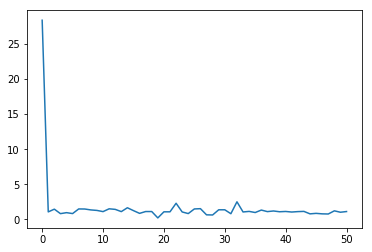